# Bitcoin Price. Prediction by ARIMA

In [19]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

## Data Exploration

In [20]:
# Load data
df = pd.read_csv('combined_data.csv')
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2020-01-01 00:00:00,7189.43,7190.52,7177.00,7182.44,246.092,1.767541e+06,7184.8475
1,2020-01-01 00:01:00,7182.43,7182.44,7178.75,7179.01,70.909,5.090564e+05,7180.6575
2,2020-01-01 00:02:00,7179.01,7179.01,7175.25,7177.93,99.420,7.136298e+05,7177.8000
3,2020-01-01 00:03:00,7177.77,7182.60,7177.00,7181.11,69.330,4.978664e+05,7179.6200
4,2020-01-01 00:04:00,7179.10,7179.10,7172.94,7175.25,97.368,6.986397e+05,7176.5975


In [21]:
import pandas as pd

# Прочети файла с данни
df = pd.read_csv('combined_data.csv')
# Преобразуване на Unix времето към формат на datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Задаване на Timestamp като индекс
df.index = df['Timestamp']

# Ресемплиране до дневна честота
df = df.resample('D').mean()

# Ресемплиране до месечна честота
df_month = df.resample('M').mean()

# Ресемплиране до годишна честота
df_year = df.resample('A-DEC').mean()

# Ресемплиране до квартална честота
df_Q = df.resample('Q-DEC').mean()


We will predict bitcoin prices by months.

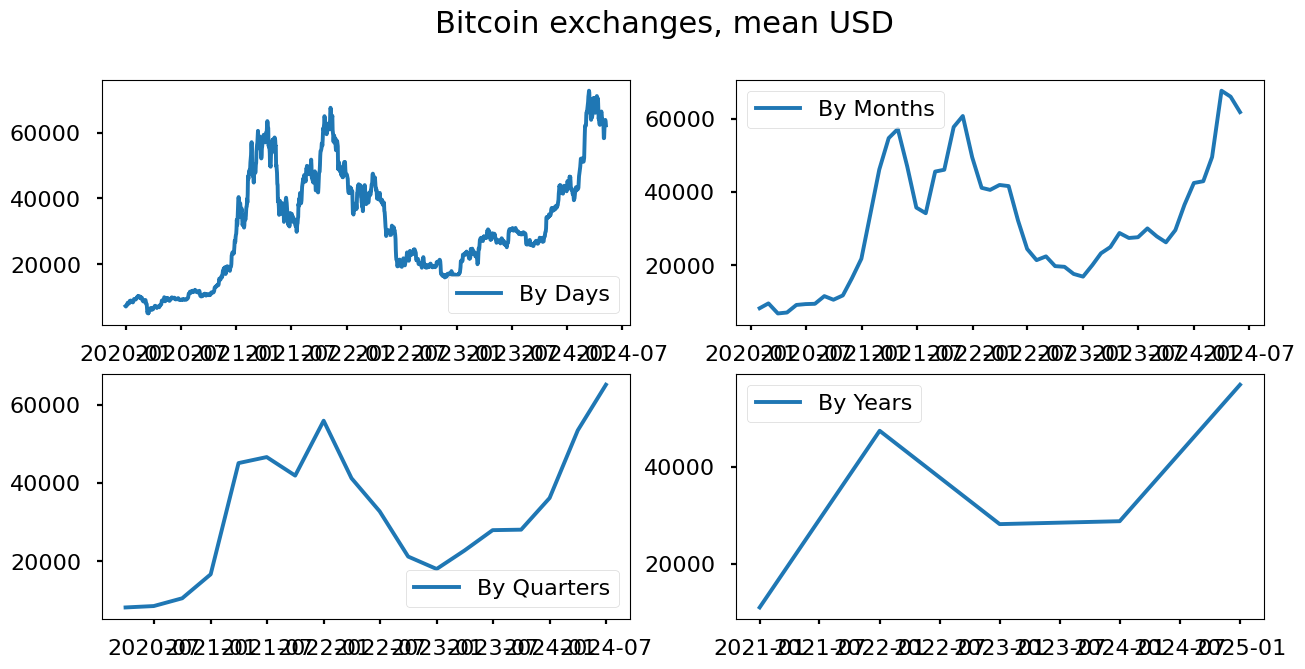

In [22]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.Weighted_Price, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Weighted_Price, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.Weighted_Price, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Weighted_Price, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

## Stationarity check and STL-decomposition of the series

Dickey–Fuller test: p=0.240583


<Figure size 1500x700 with 0 Axes>

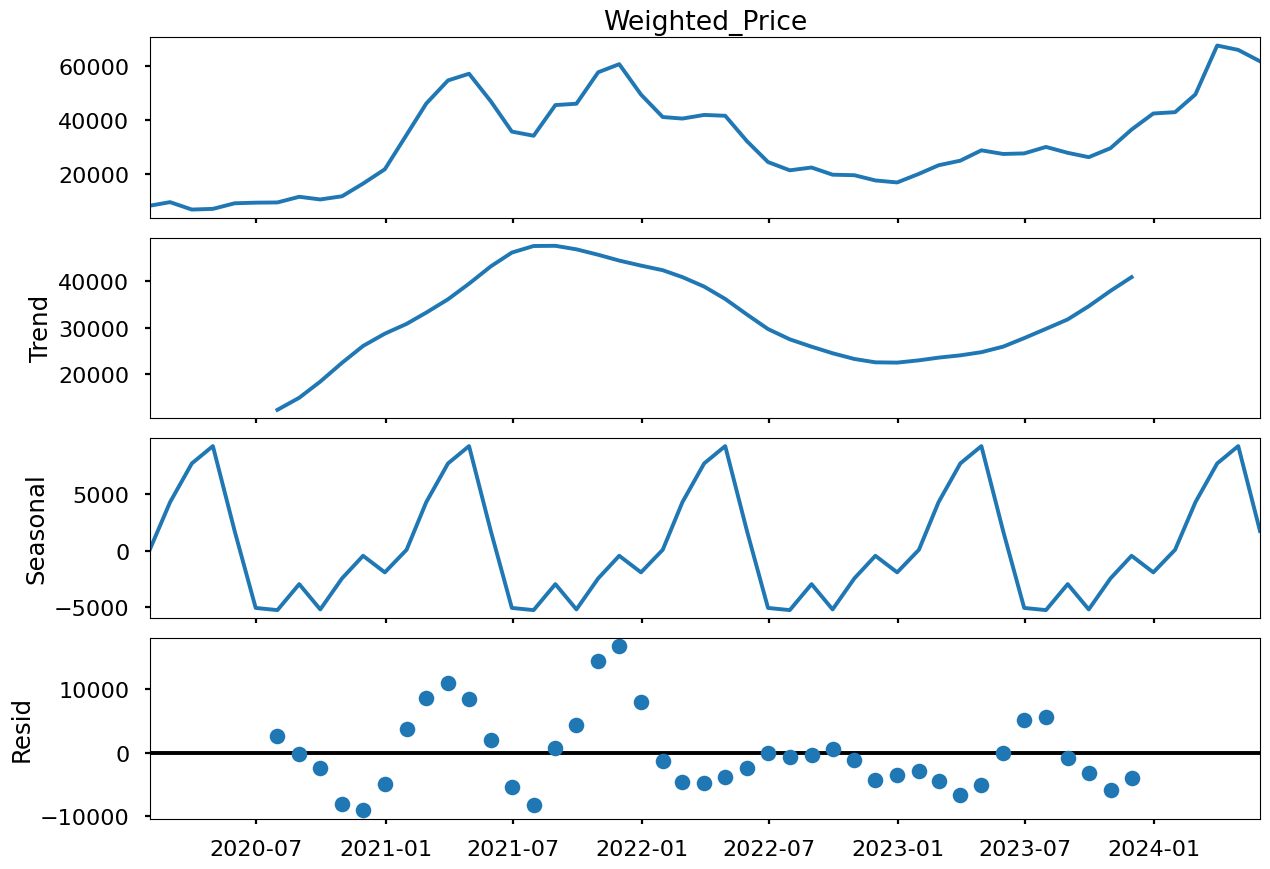

In [23]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.Weighted_Price).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])
plt.show()

The series are not stationary.

## Box-Cox Transformations

In [24]:
# Box-Cox Transformations
df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month.Weighted_Price)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])

Dickey–Fuller test: p=0.240583


The series are not stationary.

## Seasonal differentiation

In [25]:
# Seasonal differentiation
df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.000556


The series are not stationary.

## Regular differentiation

Dickey–Fuller test: p=0.014549


<Figure size 1500x700 with 0 Axes>

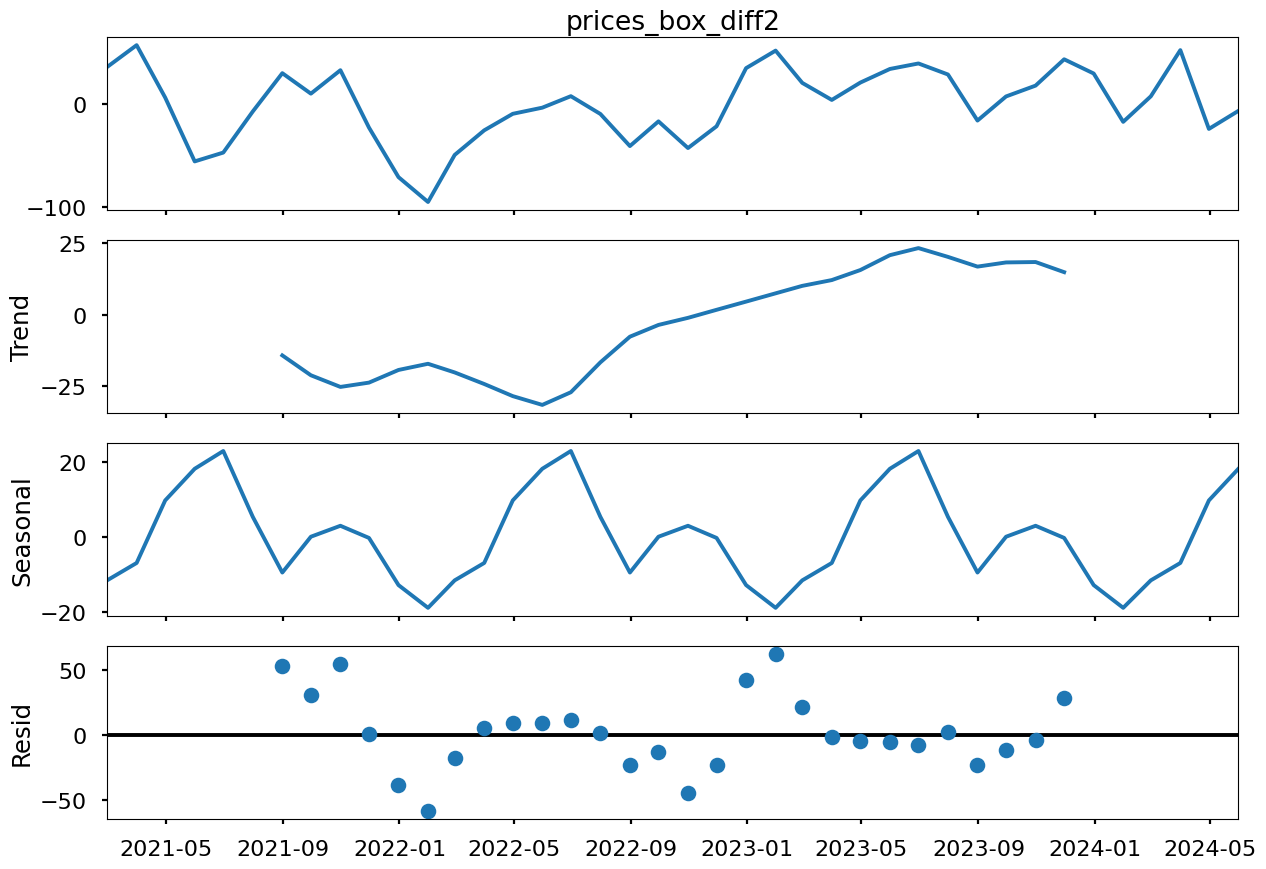

In [26]:
# Regular differentiation
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

plt.show()

The series are stationary.

## Model Selection

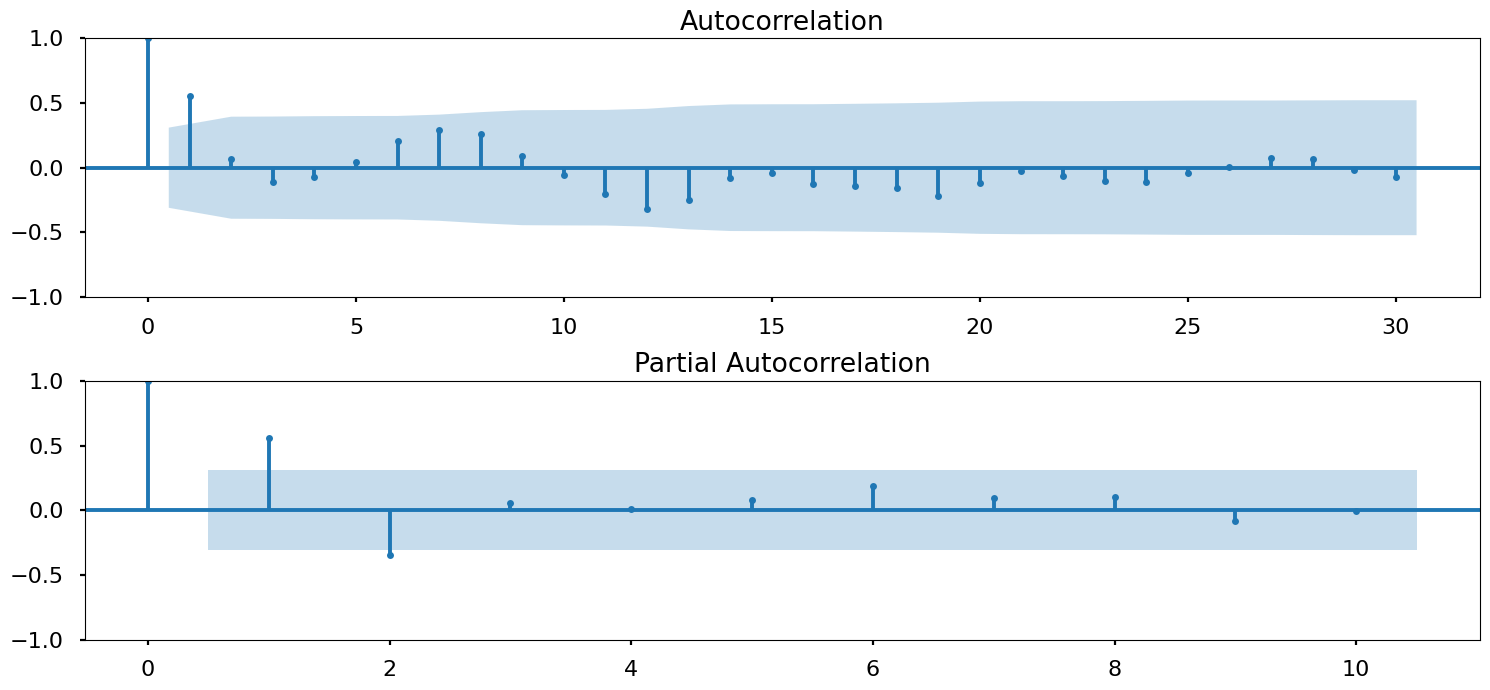

In [27]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
import matplotlib.pyplot as plt
import statsmodels.api as sm

plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.prices_box_diff2[13:].values.squeeze(), lags=30, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.prices_box_diff2[13:].values.squeeze(), lags=10, ax=ax)
plt.tight_layout()
plt.show()


In [28]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [29]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
10  (0, 1, 2, 0)  377.120601
7   (0, 1, 0, 1)  377.784106
28  (1, 1, 2, 0)  379.039476
22  (1, 0, 2, 0)  379.056491
11  (0, 1, 2, 1)  379.063824
                                      SARIMAX Results                                      
Dep. Variable:                  Weighted_Price_box   No. Observations:                   53
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -184.560
Date:                             Fri, 10 May 2024   AIC                            377.121
Time:                                     20:27:31   BIC                            383.876
Sample:                                 01-31-2020   HQIC                           379.563
                                      - 05-31-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------

## Analysis of residues

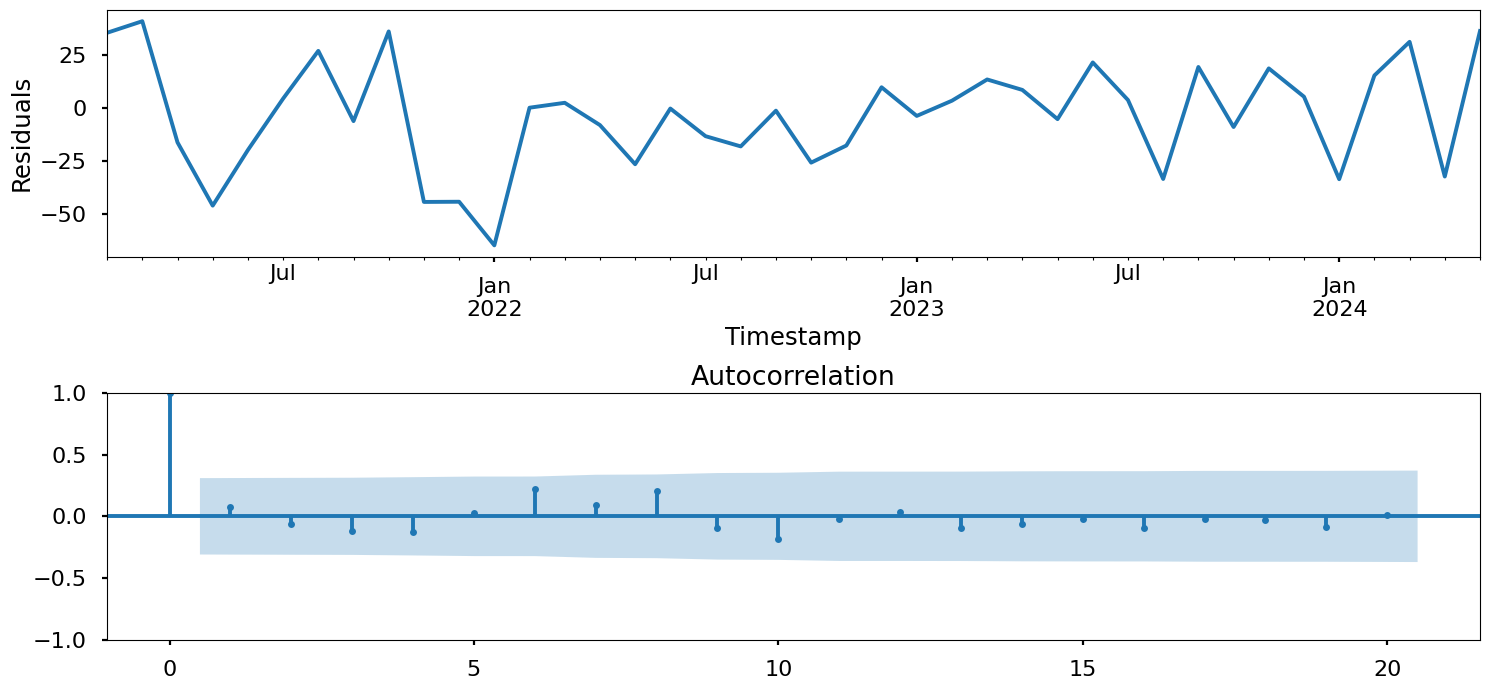

In [30]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=20, ax=ax)  # Променете броя на лаговете тук
plt.tight_layout()
plt.show()


## Prediction

In [31]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

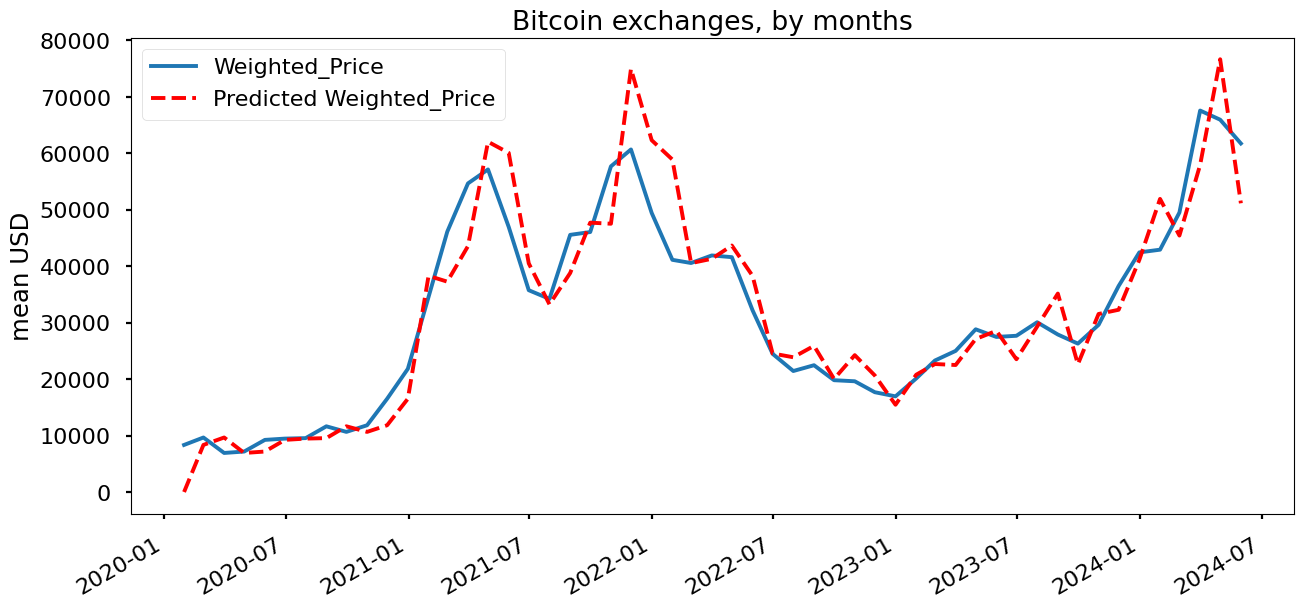

In [54]:
# Prediction
from datetime import datetime, timedelta

# Получаване на текущата дата
current_date = datetime.now()

# Генериране на списъка с дати за следващите 8 месеца от текущата дата
date_list = [current_date + timedelta(days=30*i) for i in range(1, 39)]
df_month2 = df_month[['Weighted_Price']]

future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)
plt.figure(figsize=(15,7))
df_month2.Weighted_Price.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()

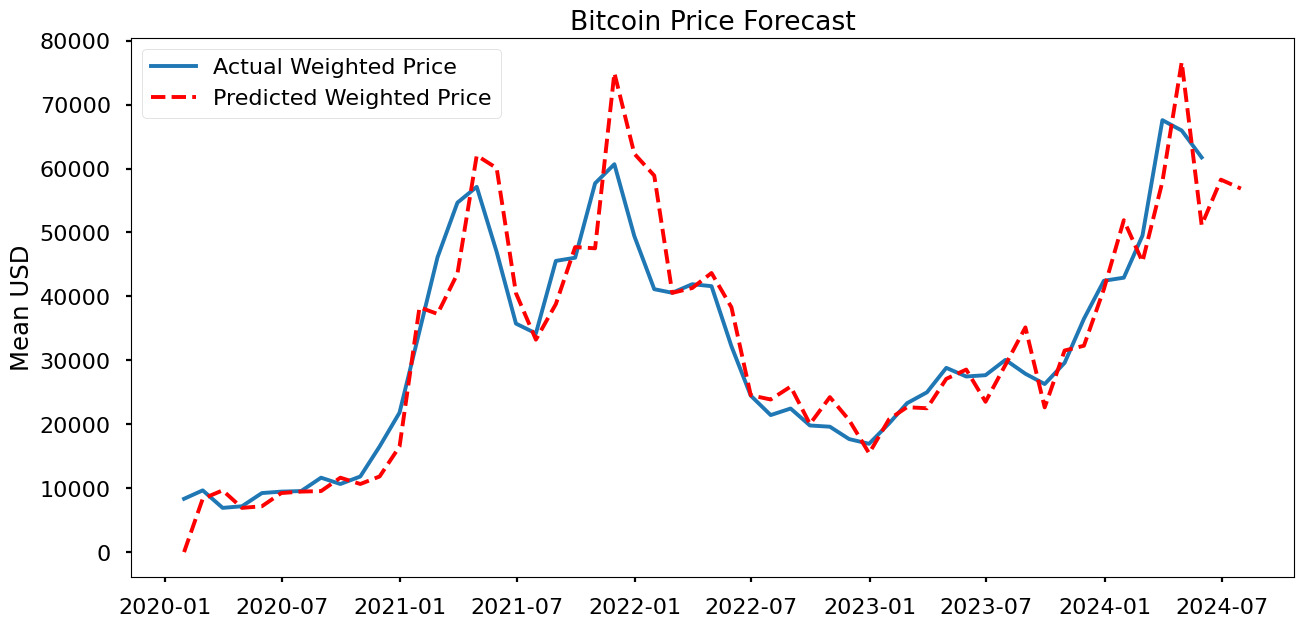

In [53]:
# Генериране на списъка с дати за следващите 8 месеца от последната налична дата
last_date = df_month.index[-1]
date_list = [last_date + pd.DateOffset(months=i) for i in range(1,3)]
# Създаване на нов DataFrame за бъдещите периоди
future = pd.DataFrame(index=date_list, columns=df_month.columns)
df_future = pd.concat([df_month, future])

# Прилагане на предсказанията към новата DataFrame
df_future['forecast'] = invboxcox(best_model.predict(start=0, end=len(df_future)-1), lmbda)
plt.figure(figsize=(15,7))
plt.plot(df_future.Weighted_Price, label='Actual Weighted Price')
plt.plot(df_future.forecast, color='r', ls='--', label='Predicted Weighted Price')
plt.legend()
plt.title('Bitcoin Price Forecast')
plt.ylabel('Mean USD')
plt.show()


In [35]:
print("Брой налични данни:", len(df_month))
print("Брой налични данни:", len(df_month))


Брой налични данни: 53
Брой налични данни: 53
